In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
# 库文件
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from skopt import gp_minimize
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error
from scipy.optimize import minimize
from sklearn.metrics.pairwise import rbf_kernel
import pandas as pd
import tensorflow as tf
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties
import seaborn as sns
import matplotlib.pyplot as plt
# 设置中文字体
font = FontProperties(fname=r"c:\windows\fonts\simsun.ttc", size=12)  # 替换为你的中文字体文件路径


In [3]:
# 读取Excel文件
excel_path = f"趋势变量加随机噪声-专用数据1.xlsx"
# df_sheet = pd.read_excel(excel_path, sheet_name='剔除异常值') 
df_sheet = pd.read_excel(excel_path, sheet_name='主参数全') 
print(df_sheet.columns)
print(df_sheet.info())




Index(['时间戳', '时间差', '富氧率', '透气性指数', 'CO', 'H2', 'CO2', '标准风速', '富氧流量', '冷风流量',
       '鼓风动能', '炉腹煤气量', '炉腹煤气指数', '理论燃烧温度', '顶压', '富氧压力', '冷风压力', '全压差',
       '热风压力', '实际风速', '热风温度', '顶温东北', '顶温西南', '顶温西北', '顶温东南', '阻力系数', '鼓风湿度',
       '设定喷煤量', '上小时喷煤量'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7453 entries, 0 to 7452
Data columns (total 29 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   时间戳     7453 non-null   int64  
 1   时间差     7453 non-null   int64  
 2   富氧率     7453 non-null   float64
 3   透气性指数   7453 non-null   float64
 4   CO      7453 non-null   float64
 5   H2      7453 non-null   float64
 6   CO2     7453 non-null   float64
 7   标准风速    7453 non-null   int64  
 8   富氧流量    7453 non-null   int64  
 9   冷风流量    7453 non-null   float64
 10  鼓风动能    7453 non-null   int64  
 11  炉腹煤气量   7453 non-null   int64  
 12  炉腹煤气指数  7453 non-null   float64
 13  理论燃烧温度  7453 non-null   int64  
 14  顶压      7453 no

In [34]:
# input_term = 'SI'
# input_term = '铁口1温度'
input_term = '富氧流量'
# input_term = '冷风流量'
# input_term = '热风压力'
# input_term = '热风温度'
# input_term = '鼓风湿度'
# input_term = '设定喷煤量'
# input_term = '冷风压力'

d_time = '时间差'
time_term = '时间戳'


In [35]:
# 数据归一化、逆归一化
from sklearn.preprocessing import MinMaxScaler

# 将数据存储为字典，每个键对应一列数据
original_data_dict = {
    time_term:  df_sheet[time_term].values,
    input_term:   df_sheet[input_term].values,
    d_time:   df_sheet[d_time].values
}

# 初始化缩放器
scalers = {}

# 进行拟合
for column, data in original_data_dict.items():
    scaler = MinMaxScaler(feature_range=(1, 10))
    scaler.fit(data.reshape(-1, 1))  # 保证数据是列向量
    scalers[column] = scaler

# 进行归一化
normalized_data_dict = {}
for column, scaler in scalers.items():
    normalized_data_dict[column] = scaler.transform(original_data_dict[column].reshape(-1, 1)).flatten()

# 进行反归一化
original_data_dict = {}
for column, scaler in scalers.items():
    original_data_dict[column] = scaler.inverse_transform(normalized_data_dict[column].reshape(-1, 1)).flatten()


In [36]:
import numpy as np

def check_stationarity(X):
    # 计算时间序列的长度
    n = len(X)
    
    # 计算时间序列的均值
    mean_X = np.mean(X)
    
    # 计算时间序列的方差
    var_X = np.var(X)
    
    # 计算时间序列的自相关系数
    autocov_X = np.correlate(X - mean_X, X - mean_X, mode='full') / n
    
    # 根据定义检查平稳性
    condition_1 = np.abs(mean_X) < 1e-6 # 使用一个极小的值来判断均值是否为零
    condition_2 = var_X < np.inf
    condition_3 = np.allclose(autocov_X[:n], autocov_X[n-1:]) # 检查自相关系数是否在时间偏移后保持不变
    
    return condition_1 and condition_2 and condition_3




In [37]:
# 示例时间序列
X = normalized_data_dict[input_term]
# 检查时间序列的平稳性
if check_stationarity(X):
    print("时间序列是平稳的。")
else:
    print("时间序列不是平稳的。")


时间序列不是平稳的。


In [38]:
# 生成数据
print(len(normalized_data_dict[input_term]))
index = np.arange(0, len(normalized_data_dict[input_term]), 1)
t           = normalized_data_dict[time_term][index]
y_observed  = normalized_data_dict[input_term][index]  # 观察到的数据
delta       = normalized_data_dict[d_time][index][:-1]


7453


In [39]:
# 建立MLP趋势分量
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

# 将数据转换为 PyTorch 张量
t_tensor = torch.tensor(t, dtype=torch.float32).view(-1, 1)
y_observed_tensor = torch.tensor(y_observed, dtype=torch.float32).view(-1, 1)

# 定义包含两个隐藏层的前馈神经网络模型
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.hidden_layer1 = nn.Linear(1, 10)  # 第一个隐藏层
        self.hidden_layer2 = nn.Linear(10, 100)  # 第二个隐藏层
        self.hidden_layer3 = nn.Linear(100, 1000)  # 第二个隐藏层
        self.hidden_layer4 = nn.Linear(1000, 32)  # 第二个隐藏层
        self.output_layer = nn.Linear(32, 1)  # 输出层

    def forward(self, x):
        x = torch.relu(self.hidden_layer1(x))
        x = torch.relu(self.hidden_layer2(x))
        x = torch.relu(self.hidden_layer3(x))
        x = torch.relu(self.hidden_layer4(x))
        x = self.output_layer(x)
        return x

# 初始化模型、损失函数和优化器
model = NeuralNetwork()
criterion = nn.MSELoss()  # 使用均方误差作为损失函数
optimizer = optim.Adam(model.parameters(), lr=0.001)  # Adam优化器



In [40]:
# 训练趋势分量模型
epochs = 1000
for epoch in range(epochs):
    # 前向传播
    y_pred = model(t_tensor)
    
    # 计算损失
    loss = criterion(y_pred, y_observed_tensor)
    
    # 反向传播和优化
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if epoch % 10 == 0:
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}',end='\r')



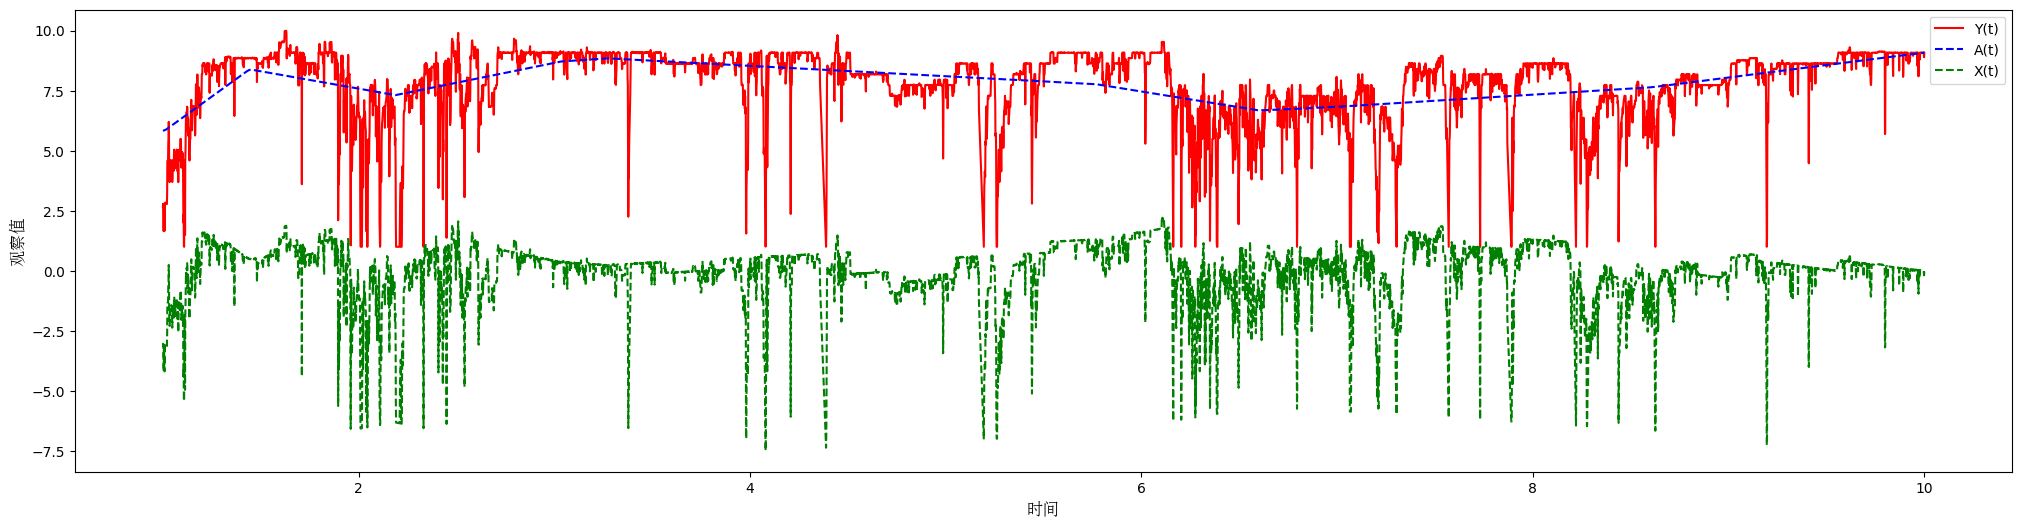

In [41]:
# 将模型转换为评估模式
model.eval()

# 使用训练好的模型进行预测
with torch.no_grad():
    trend_component_nn = model(t_tensor).numpy()

y_trend = trend_component_nn.reshape(trend_component_nn.shape[0])



# 绘制结果
plt.figure(figsize=(25, 6))
plt.plot(t, y_observed, 'r', label='Y(t)')
plt.plot(t, y_trend, 'b', label='A(t)', linestyle='--')
plt.plot(t, y_observed-y_trend, 'g', label='X(t)', linestyle='--')

plt.xlabel('时间', fontproperties=font)  # 使用中文标签
plt.ylabel('观察值', fontproperties=font)  # 使用中文标签
plt.legend()
plt.show()


In [42]:
# 噪声分量参数估计
import numpy as np
from scipy.optimize import minimize

# 假设观测值为 x，时间间隔为 delta
# 你需要提供你的观测值 x 和时间间隔 delta
# 示例数据：
X = (y_observed-trend_component_nn.reshape(trend_component_nn.shape[0]))


print(X.shape)
print(delta.shape)

# 定义最小二乘法的目标函数
def least_squares_objective(theta, x, delta):
    n = len(x)
    residuals = x[1:] - theta ** delta * x[:-1]
    return np.sum(residuals**2)




# 通过最小二乘法估计参数 theta
initial_guess_theta = 0.5  # 初始猜测值
result_theta = minimize(least_squares_objective, initial_guess_theta, args=(X, delta))
estimated_theta = result_theta.x[0]

# # 估计σ
# residuals = x[1:] - estimated_theta ** delta * x[:-1]
# sigma_square_delta = np.mean(residuals**2) / (1 - estimated_theta**2 * np.mean(delta**2) / (1 - estimated_theta**2))
# estimated_sigma = np.sqrt(sigma_square_delta)
# 估计σ

sum_0 = 0
for i in range(len(delta)):
    sum_0 = sum_0 + (X[i+1] - estimated_theta ** delta[i] * X[i])**2 / ((1-estimated_theta**(2*delta[i])) /(1-estimated_theta**(2))) 

estimated_sigma = np.sqrt(sum_0/(len(delta)+1))

print(f"Estimated theta: {estimated_theta}")
print(f"Estimated sigma: {estimated_sigma}")




(7453,)
(7452,)
Estimated theta: 0.9892105172257295
Estimated sigma: 0.17990663773613294


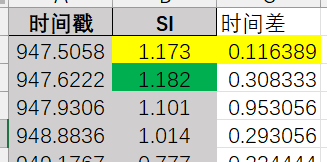

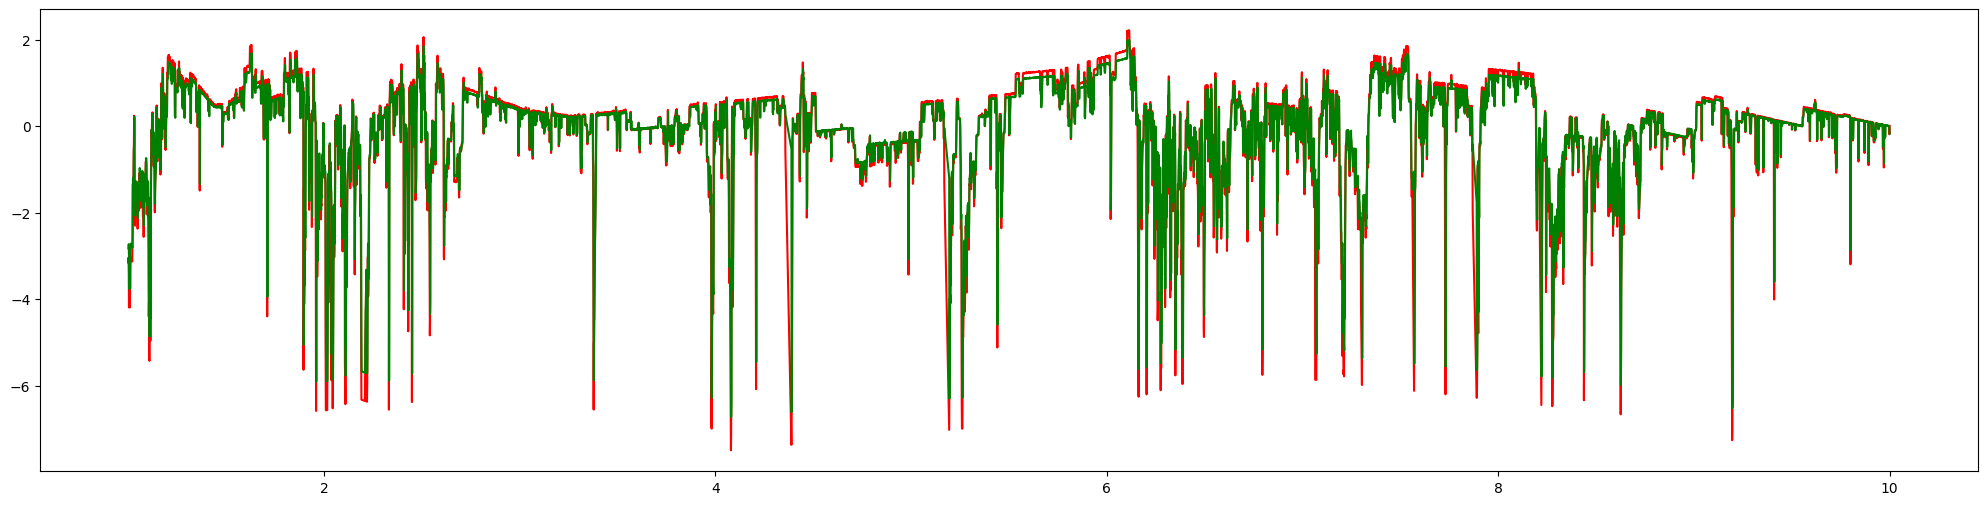

In [43]:
# 一步预测
def one_step_predictor(theta, x, delta):
    return theta ** delta * x

# 使用估计的参数进行一步预测
predicted_values = one_step_predictor(estimated_theta, X[:-1], delta)

plt.figure(figsize=(25, 6))
plt.plot(t, y_observed-y_trend, 'r')
plt.plot(t[1:],predicted_values, 'g')


In [44]:
# 预测
# 时间戳范围
timestamps_to_predict = np.arange(np.floor(min(df_sheet[time_term][index]))+1,
                                np.floor(max(df_sheet[time_term][index]))+1,
                                1)
df_sheet2 = df_sheet
df_sheet3 = pd.DataFrame()
isprint = 0
for id,y_predict_time in enumerate(timestamps_to_predict):
    print(y_predict_time,end='\r')
    if isprint:
        print(id,y_predict_time,'000000000000000000000000000000000000000000000000000000000000000000000')
    # y_predict_time = 950

    # 找到比 item 小且最接近的1个数据
    closest_10 = df_sheet[df_sheet[time_term] < y_predict_time].nlargest(1, time_term)
    closest_10_sorted = closest_10.sort_values(by=time_term)
    if isprint:
        print('df:')
        print(closest_10_sorted)
        print('  ')

    y_last_predict_time = closest_10_sorted.iloc[-1][time_term]
    y_last_predict_time_transform = scalers[time_term].transform(y_last_predict_time.reshape(-1,1)).flatten()
    if isprint:
        print('y_last_predict_time:')
        print(y_last_predict_time)
        print(y_last_predict_time_transform)
        print('  ')

    delta_to_predict = y_predict_time - y_last_predict_time
    delta_to_predict_transform = scalers[d_time].transform(delta_to_predict.reshape(-1,1)).flatten()
    if isprint:
        print('delta_to_predict:')
        print(delta_to_predict)
        print(delta_to_predict_transform)
        print('  ')


    y_last_observed_to_predict = closest_10_sorted.iloc[-1][input_term]
    y_last_observed_to_predict_transform = scalers[input_term].transform(y_last_observed_to_predict.reshape(-1,1)).flatten()

    if isprint:
        print('y_last_observed_to_predict:')
        print(y_last_observed_to_predict)
        print(y_last_observed_to_predict_transform)
        print('  ')


    # 将数据转换为 PyTorch 张量
    y_last_predict_time_transform_tensor = torch.tensor(y_last_predict_time_transform, dtype=torch.float32).view(-1, 1)

    with torch.no_grad():
        trend_component_nn = model(y_last_predict_time_transform_tensor).numpy()

    y_last_predict_time_trend_predict = trend_component_nn.reshape(trend_component_nn.shape[0])
    if isprint:
        print(y_last_predict_time_trend_predict)


    X_last_predict_time  = y_last_observed_to_predict_transform-y_last_predict_time_trend_predict
    if isprint:
        print('X_last_predict_time:')
        print(X_last_predict_time)


    # 将数据转换为 PyTorch 张量
    y_predict_time = np.array(y_predict_time)
    y_predict_time_transform = scalers[time_term].transform(y_predict_time.reshape(-1,1)).flatten()
    y_predict_time_transform_tensor = torch.tensor(y_predict_time_transform, dtype=torch.float32).view(-1, 1)

    with torch.no_grad():
        trend_component_nn = model(y_predict_time_transform_tensor).numpy()

    y_predict_time_trend_predict = trend_component_nn.reshape(trend_component_nn.shape[0])
    if isprint:
        print('y_predict_time_trend_predict')
        print(y_predict_time_trend_predict)



    # 使用估计的参数进行一步预测
    predicted_values = (estimated_theta ** delta_to_predict_transform * X_last_predict_time
                        + y_predict_time_trend_predict)


    if isprint:
        print(predicted_values)
    predicted_values = scalers[input_term].inverse_transform((predicted_values.reshape(-1,1))).flatten()

    if isprint:
        print(predicted_values)
        


    new_row = {time_term: y_predict_time, input_term: predicted_values.item(), d_time: delta_to_predict}
    df_sheet2 = pd.concat([df_sheet2, pd.DataFrame([new_row])], ignore_index=True)
    df_sheet2 = df_sheet2.sort_values(by=time_term)
    df_sheet3 = pd.concat([df_sheet3, pd.DataFrame([new_row])], ignore_index=True)
    df_sheet3 = df_sheet3.sort_values(by=time_term)






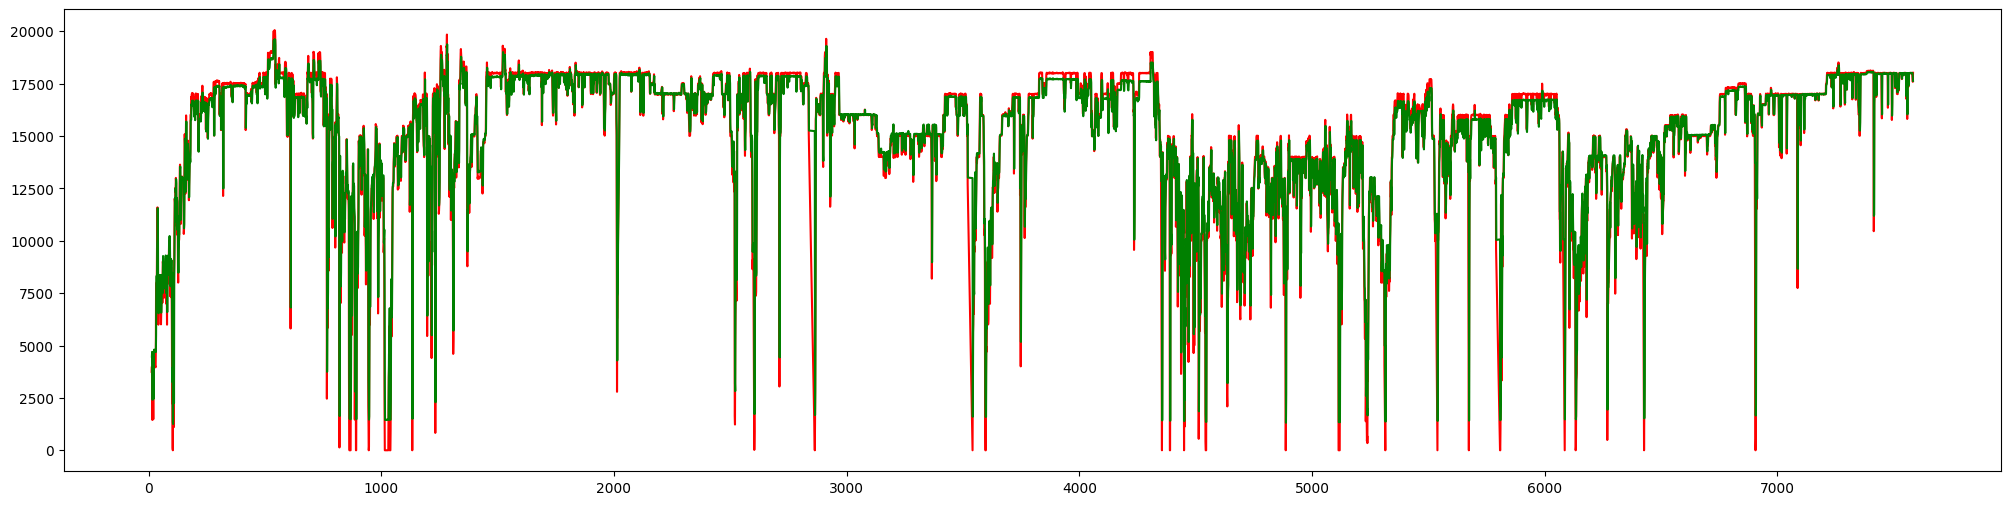

In [45]:
# 绘制结果
plt.figure(figsize=(25, 6))
plt.plot(df_sheet['时间戳'][index],df_sheet[input_term][index],'r-', label='填充后数据') # 使用中文标签
plt.plot(df_sheet3['时间戳'][:],df_sheet3[input_term][:],'g-', label = '填充后数据') # 使用中文标签


In [46]:
df_sheet3.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7570 entries, 0 to 7569
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   时间戳     7570 non-null   object 
 1   富氧流量    7570 non-null   float64
 2   时间差     7570 non-null   float64
dtypes: float64(2), object(1)
memory usage: 177.5+ KB


In [47]:
df_sheet3.tail()


,时间戳,富氧流量,时间差
7565,7579.0,18006.882557,1.0
7566,7580.0,17999.061207,1.0
7567,7581.0,17991.247699,1.0
7568,7582.0,17753.684957,1.0
7569,7583.0,17629.186914,1.0


In [48]:
# 保存整理后的 df_sheet 到 Excel 文件
df_sheet3.to_excel('000_'+input_term+'_output.xlsx', index=False)
print('DataFrame 已保存到'+input_term+' output.xlsx 文件')

df_sheet.to_excel('000_'+input_term+'_output0.xlsx', index=False)
print('DataFrame 已保存到'+input_term+' output.xlsx 文件')

df_sheet2.to_excel('000_'+input_term+'_output2.xlsx', index=False)
print('DataFrame 已保存到'+input_term+' output.xlsx 文件')


DataFrame 已保存到富氧流量 output.xlsx 文件
DataFrame 已保存到富氧流量 output.xlsx 文件
DataFrame 已保存到富氧流量 output.xlsx 文件
